# Méthodes d'Optimisation — Online Learning (From Scratch, sans NumPy)

**Cours : Online Learning / Optimisation Numérique — Pr. Afia**  
**Étudiant : Salmane Sossey**

---

Ce notebook implémente **from scratch** (sans NumPy) :
1. **Algèbre linéaire** : opérations vecteur/matrice en pur Python
2. **Dérivées numériques** via la définition de la limite ($h \to 0$) :
   - Différence **avant** (forward)
   - Différence **arrière** (backward)
   - Différence **centrée** (central)
3. **Méthodes d'optimisation** :
   - Gradient Descent à pas fixe
   - Gradient Descent avec **règle d'Armijo** (line search)
   - Gradient Descent **Self-Adaptive** (auto-adaptation du pas)
   - Méthode de **Newton**
   - **Quasi-Newton (BFGS)**
4. **Comparaisons** et détermination de la meilleure méthode

Tous les graphiques sont enregistrés dans `images/`.

## 1. Imports minimaux (uniquement pour le chargement des données et les graphiques)

In [1]:
import csv, os, time, math, copy
import matplotlib.pyplot as plt          # uniquement pour les plots
import kagglehub

os.makedirs('images', exist_ok=True)
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ Imports (csv, os, time, math, matplotlib) — PAS de NumPy / SciPy")

✓ Imports (csv, os, time, math, matplotlib) — PAS de NumPy / SciPy


/home/salmane/notebooks_algos/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Algèbre linéaire « from scratch » (pur Python)

Aucune bibliothèque externe — toutes les opérations vectorielles/matricielles sont implémentées manuellement.

In [2]:
# ── Opérations vectorielles from scratch ──────────────────────────────────

def vec_add(a, b):
    """Addition de deux vecteurs."""
    return [ai + bi for ai, bi in zip(a, b)]

def vec_sub(a, b):
    """Soustraction de deux vecteurs."""
    return [ai - bi for ai, bi in zip(a, b)]

def vec_scale(alpha, a):
    """Multiplication scalaire * vecteur."""
    return [alpha * ai for ai in a]

def dot(a, b):
    """Produit scalaire de deux vecteurs."""
    return sum(ai * bi for ai, bi in zip(a, b))

def vec_norm(a):
    """Norme euclidienne d'un vecteur."""
    return math.sqrt(sum(ai * ai for ai in a))

def zeros(n):
    """Vecteur nul de taille n."""
    return [0.0] * n

# ── Opérations matricielles from scratch ─────────────────────────────────

def mat_vec_mul(M, v):
    """Produit matrice × vecteur.  M : liste de lignes."""
    return [dot(row, v) for row in M]

def mat_transpose(M):
    """Transposée d'une matrice."""
    rows, cols = len(M), len(M[0])
    return [[M[i][j] for i in range(rows)] for j in range(cols)]

def mat_mul(A, B):
    """Produit matriciel A × B."""
    BT = mat_transpose(B)
    return [[dot(a_row, b_col) for b_col in BT] for a_row in A]

def mat_scale(alpha, M):
    """Scalaire × matrice."""
    return [[alpha * M[i][j] for j in range(len(M[0]))] for i in range(len(M))]

def mat_add(A, B):
    return [[A[i][j] + B[i][j] for j in range(len(A[0]))] for i in range(len(A))]

def mat_sub(A, B):
    return [[A[i][j] - B[i][j] for j in range(len(A[0]))] for i in range(len(A))]

def identity(n):
    """Matrice identité n×n."""
    return [[1.0 if i == j else 0.0 for j in range(n)] for i in range(n)]

def solve_2x2(M, b):
    """Résout M·x = b pour une matrice 2×2 (Cramer)."""
    det = M[0][0]*M[1][1] - M[0][1]*M[1][0]
    if abs(det) < 1e-15:
        raise ValueError("Matrice singulière")
    inv = [[M[1][1]/det, -M[0][1]/det],
           [-M[1][0]/det, M[0][0]/det]]
    return mat_vec_mul(inv, b)

def outer(a, b):
    """Produit extérieur de deux vecteurs → matrice."""
    return [[ai * bj for bj in b] for ai in a]

print("✓ Algèbre linéaire from scratch implémentée (vec_add, dot, mat_mul, solve_2x2, ...)")

✓ Algèbre linéaire from scratch implémentée (vec_add, dot, mat_mul, solve_2x2, ...)


## 3. Chargement et préparation du dataset (sans NumPy)

In [3]:
# Télécharger le dataset
path = kagglehub.dataset_download("tanuprabhu/linear-regression-dataset")
dataset_file = os.path.join(path, "Linear Regression - Sheet1.csv")

# Lecture CSV pure Python
with open(dataset_file, 'r') as f:
    reader = csv.DictReader(f)
    rows = list(reader)

X_raw = [float(r['X']) for r in rows]
y_raw = [float(r['Y']) for r in rows]
n = len(X_raw)

# Statistiques from scratch
def mean(v):  return sum(v) / len(v)
def std(v):
    m = mean(v)
    return math.sqrt(sum((x - m)**2 for x in v) / len(v))

X_m, X_s = mean(X_raw), std(X_raw)
y_m, y_s = mean(y_raw), std(y_raw)

# Normalisation
X_norm = [(x - X_m) / X_s for x in X_raw]
y_norm = [(y - y_m) / y_s for y in y_raw]

# Matrice X avec intercept (colonne de 1) — liste de lignes [1.0, xi]
X = [[1.0, xi] for xi in X_norm]
y = y_norm[:]                           # cible normalisée
p = 2                                   # nombre de paramètres (intercept + pente)

print(f"Dataset: {n} échantillons, {p} paramètres (intercept + 1 feature)")
print(f"5 premières lignes X : {X[:5]}")
print(f"5 premières valeurs y : {[round(yi,4) for yi in y[:5]]}")

Dataset: 300 échantillons, 2 paramètres (intercept + 1 feature)
5 premières lignes X : [[1.0, -1.7262868953863735], [1.0, -1.7147398258520166], [1.0, -1.7031927563176594], [1.0, -1.6916456867833025], [1.0, -1.6800986172489454]]
5 premières valeurs y : [-1.7027, -1.6912, -1.6796, -1.6681, -1.6566]


## 4. Fonction de coût (MSE) — from scratch

$$J(\theta) = \frac{1}{2n}\sum_{i=1}^{n}\bigl(x^{(i)T}\theta - y^{(i)}\bigr)^2$$

In [4]:
def cost(theta, X, y):
    """MSE / 2  — from scratch."""
    n = len(y)
    s = 0.0
    for i in range(n):
        pred = dot(X[i], theta)
        s += (pred - y[i]) ** 2
    return s / (2 * n)

# Test rapide
theta0 = zeros(p)
print(f"Coût initial (θ = [0,0]) : {cost(theta0, X, y):.6f}")

Coût initial (θ = [0,0]) : 0.500000


## 5. Dérivées Numériques « From Scratch » — Définition par la Limite

Trois approches de la définition de la dérivée $f'(x) = \lim_{h\to 0}\ldots$ :

| Méthode | Formule | Erreur |
|---------|---------|--------|
| **Forward** (avant) | $\dfrac{f(x+h)-f(x)}{h}$ | $\mathcal{O}(h)$ |
| **Backward** (arrière) | $\dfrac{f(x)-f(x-h)}{h}$ | $\mathcal{O}(h)$ |
| **Central** (centrée) | $\dfrac{f(x+h)-f(x-h)}{2h}$ | $\mathcal{O}(h^2)$ |

In [5]:
def gradient_forward(theta, X, y, h=1e-7):
    """Gradient par différence AVANT :  (f(θ+h·eⱼ) - f(θ)) / h"""
    g = zeros(len(theta))
    f0 = cost(theta, X, y)
    for j in range(len(theta)):
        theta_h = theta[:]
        theta_h[j] += h
        g[j] = (cost(theta_h, X, y) - f0) / h
    return g

def gradient_backward(theta, X, y, h=1e-7):
    """Gradient par différence ARRIÈRE :  (f(θ) - f(θ-h·eⱼ)) / h"""
    g = zeros(len(theta))
    f0 = cost(theta, X, y)
    for j in range(len(theta)):
        theta_h = theta[:]
        theta_h[j] -= h
        g[j] = (f0 - cost(theta_h, X, y)) / h
    return g

def gradient_central(theta, X, y, h=1e-7):
    """Gradient par différence CENTRÉE :  (f(θ+h·eⱼ) - f(θ-h·eⱼ)) / 2h"""
    g = zeros(len(theta))
    for j in range(len(theta)):
        tp = theta[:]; tp[j] += h
        tm = theta[:]; tm[j] -= h
        g[j] = (cost(tp, X, y) - cost(tm, X, y)) / (2 * h)
    return g

def gradient_analytical(theta, X, y):
    """Gradient analytique (exact) :  ∇J = (1/n) Xᵀ(Xθ - y)"""
    n = len(y)
    g = zeros(len(theta))
    for i in range(n):
        err = dot(X[i], theta) - y[i]
        for j in range(len(theta)):
            g[j] += err * X[i][j]
    return vec_scale(1.0 / n, g)

# ── Comparaison des 4 méthodes ──────────────────────────────────────────
theta_test = [0.1, 0.5]
g_fwd = gradient_forward(theta_test, X, y)
g_bwd = gradient_backward(theta_test, X, y)
g_ctr = gradient_central(theta_test, X, y)
g_ana = gradient_analytical(theta_test, X, y)

print("Comparaison des gradients en θ = [0.1, 0.5] :")
print(f"  Forward    : [{g_fwd[0]:.10f}, {g_fwd[1]:.10f}]")
print(f"  Backward   : [{g_bwd[0]:.10f}, {g_bwd[1]:.10f}]")
print(f"  Central    : [{g_ctr[0]:.10f}, {g_ctr[1]:.10f}]")
print(f"  Analytique : [{g_ana[0]:.10f}, {g_ana[1]:.10f}]")
print(f"\nErreur vs analytique:")
print(f"  Forward    : {abs(g_fwd[0]-g_ana[0]):.2e}, {abs(g_fwd[1]-g_ana[1]):.2e}")
print(f"  Backward   : {abs(g_bwd[0]-g_ana[0]):.2e}, {abs(g_bwd[1]-g_ana[1]):.2e}")
print(f"  Central    : {abs(g_ctr[0]-g_ana[0]):.2e}, {abs(g_ctr[1]-g_ana[1]):.2e}")

Comparaison des gradients en θ = [0.1, 0.5] :
  Forward    : [0.1000000505, -0.4598757580]
  Backward   : [0.0999999489, -0.4598758593]
  Central    : [0.0999999997, -0.4598758087]
  Analytique : [0.1000000000, -0.4598758089]

Erreur vs analytique:
  Forward    : 5.05e-08, 5.09e-08
  Backward   : 5.11e-08, 5.04e-08
  Central    : 3.30e-10, 2.27e-10


In [ ]:
### 5.1 Visualisation : précision des dérivées en fonction de $h$

✓ images/derivees_precision_vs_h.png


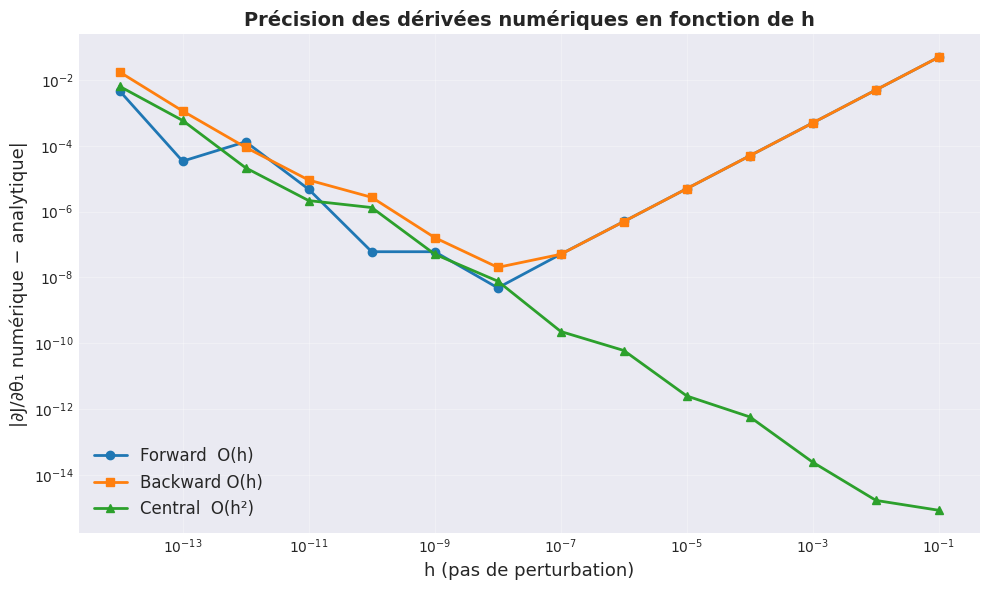

In [6]:
# Erreur de chaque méthode numérique en fonction de h
hs = [10**(-k) for k in range(1, 15)]
err_fwd, err_bwd, err_ctr = [], [], []
theta_test = [0.1, 0.5]
g_exact = gradient_analytical(theta_test, X, y)

for h in hs:
    gf = gradient_forward(theta_test, X, y, h=h)
    gb = gradient_backward(theta_test, X, y, h=h)
    gc = gradient_central(theta_test, X, y, h=h)
    # erreur relative sur la composante θ₁
    err_fwd.append(abs(gf[1] - g_exact[1]) + 1e-20)
    err_bwd.append(abs(gb[1] - g_exact[1]) + 1e-20)
    err_ctr.append(abs(gc[1] - g_exact[1]) + 1e-20)

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(hs, err_fwd, 'o-', label='Forward  O(h)',   linewidth=2)
ax.loglog(hs, err_bwd, 's-', label='Backward O(h)',   linewidth=2)
ax.loglog(hs, err_ctr, '^-', label='Central  O(h²)',  linewidth=2)
ax.set_xlabel('h (pas de perturbation)', fontsize=13)
ax.set_ylabel('|∂J/∂θ₁ numérique − analytique|', fontsize=13)
ax.set_title("Précision des dérivées numériques en fonction de h", fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/derivees_precision_vs_h.png', dpi=300, bbox_inches='tight')
print("✓ images/derivees_precision_vs_h.png")
plt.show()

### 5.2 Visualisation : Coût, Gradient et Hessienne

✓ images/types_derivees.png


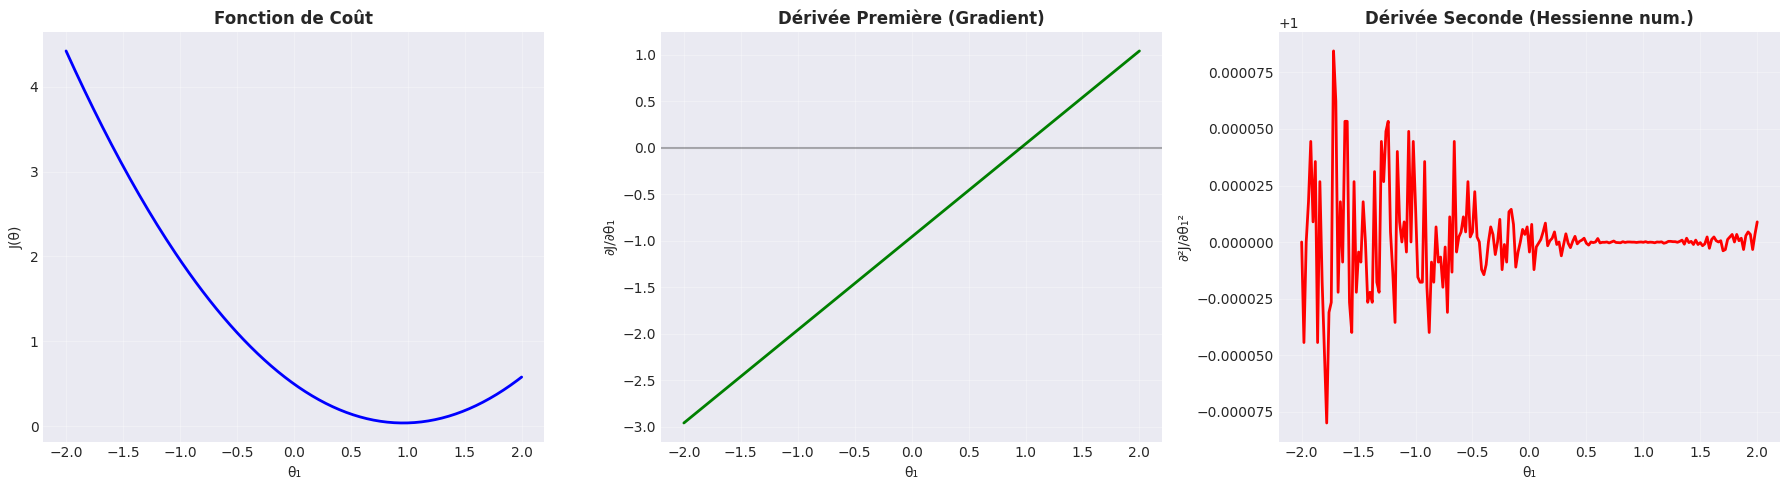

In [7]:
# Varier θ₁ en fixant θ₀ ≈ 0 pour visualiser coût / gradient / hessienne
theta_vals = [round(-2.0 + 4.0*i/200, 3) for i in range(201)]
costs_curve = []
grads_curve = []

for t1 in theta_vals:
    theta_t = [0.0, t1]
    costs_curve.append(cost(theta_t, X, y))
    grads_curve.append(gradient_analytical(theta_t, X, y)[1])

# Hessienne ∂²J/∂θ₁² par différence centrée
def hessian_numerical(theta, X, y, j=1, h=1e-5):
    tp = theta[:]; tp[j] += h
    tm = theta[:]; tm[j] -= h
    return (cost(tp, X, y) - 2*cost(theta, X, y) + cost(tm, X, y)) / (h*h)

hess_curve = [hessian_numerical([0.0, t1], X, y) for t1 in theta_vals]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(theta_vals, costs_curve, 'b-', lw=2)
axes[0].set_xlabel('θ₁'); axes[0].set_ylabel('J(θ)')
axes[0].set_title('Fonction de Coût', fontweight='bold')

axes[1].plot(theta_vals, grads_curve, 'g-', lw=2)
axes[1].axhline(0, color='k', alpha=0.3)
axes[1].set_xlabel('θ₁'); axes[1].set_ylabel('∂J/∂θ₁')
axes[1].set_title('Dérivée Première (Gradient)', fontweight='bold')

axes[2].plot(theta_vals, hess_curve, 'r-', lw=2)
axes[2].set_xlabel('θ₁'); axes[2].set_ylabel('∂²J/∂θ₁²')
axes[2].set_title('Dérivée Seconde (Hessienne num.)', fontweight='bold')

for ax in axes: ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/types_derivees.png', dpi=300, bbox_inches='tight')
print("✓ images/types_derivees.png")
plt.show()

## 6. Méthodes d'Optimisation (from scratch)

### 6.1 Gradient Descent — pas fixe

$$\theta_{t+1} = \theta_t - \alpha\,\nabla J(\theta_t)$$

In [8]:
def gd_fixed(X, y, lr=0.1, max_iter=1000, tol=1e-10):
    """Gradient Descent à pas fixe (utilise le gradient analytique)."""
    theta = zeros(len(X[0]))
    history = []
    for k in range(max_iter):
        g = gradient_analytical(theta, X, y)
        theta = vec_sub(theta, vec_scale(lr, g))
        c = cost(theta, X, y)
        history.append(c)
        if vec_norm(g) < tol:
            break
    return theta, history

print("✓ Gradient Descent (pas fixe) implémenté")

✓ Gradient Descent (pas fixe) implémenté


### 6.2 Gradient Descent + Règle d'Armijo (Line Search)

La **règle d'Armijo** adapte le pas $\alpha$ à chaque itération :

> Choisir le plus grand $\alpha = \beta^k \hat\alpha$ tel que  
> $J(\theta - \alpha\nabla J) \le J(\theta) - c\,\alpha\,\|\nabla J\|^2$

Paramètres : $c \in (0,1)$ (souvent 1e-4), $\beta \in (0,1)$ (souvent 0.5).

In [9]:
def armijo_line_search(theta, g, X, y, alpha0=1.0, c=1e-4, beta=0.5):
    """Retourne le pas alpha satisfaisant la condition d'Armijo."""
    f0 = cost(theta, X, y)
    gnorm2 = dot(g, g)          # ||∇J||²
    alpha = alpha0
    while True:
        theta_new = vec_sub(theta, vec_scale(alpha, g))
        if cost(theta_new, X, y) <= f0 - c * alpha * gnorm2:
            return alpha
        alpha *= beta
        if alpha < 1e-20:
            return alpha

def gd_armijo(X, y, max_iter=1000, tol=1e-10):
    """Gradient Descent avec recherche de pas d'Armijo."""
    theta = zeros(len(X[0]))
    history = []
    alphas = []
    for k in range(max_iter):
        g = gradient_analytical(theta, X, y)
        alpha = armijo_line_search(theta, g, X, y)
        theta = vec_sub(theta, vec_scale(alpha, g))
        c = cost(theta, X, y)
        history.append(c)
        alphas.append(alpha)
        if vec_norm(g) < tol:
            break
    return theta, history, alphas

print("✓ Gradient Descent + Armijo implémenté")

✓ Gradient Descent + Armijo implémenté


### 6.3 Gradient Descent Self-Adaptive

Le pas est **auto-adapté** : si le coût diminue on augmente $\alpha$ (× 1.1), sinon on le divise (× 0.5) et on annule la mise à jour. Cela imite un « learning rate scheduler » en Online Learning.

In [10]:
def gd_self_adaptive(X, y, alpha0=0.1, max_iter=1000, tol=1e-10,
                     grow=1.1, shrink=0.5):
    """Gradient Descent Self-Adaptive : le pas grandit ou rétrécit selon le coût."""
    theta = zeros(len(X[0]))
    alpha = alpha0
    history = []
    alphas = []
    prev_cost = cost(theta, X, y)
    for k in range(max_iter):
        g = gradient_analytical(theta, X, y)
        theta_new = vec_sub(theta, vec_scale(alpha, g))
        new_cost = cost(theta_new, X, y)
        if new_cost < prev_cost:
            # Bonne direction → accepter et augmenter le pas
            theta = theta_new
            prev_cost = new_cost
            alpha *= grow
        else:
            # Dépasse le minimum → réduire le pas, rejeter la mise à jour
            alpha *= shrink
        history.append(prev_cost)
        alphas.append(alpha)
        if vec_norm(g) < tol:
            break
    return theta, history, alphas

print("✓ Gradient Descent Self-Adaptive implémenté")

✓ Gradient Descent Self-Adaptive implémenté


### 6.4 Méthode de Newton

$$\theta_{t+1} = \theta_t - H^{-1}(\theta_t)\,\nabla J(\theta_t)$$

La Hessienne est calculée numériquement (différences centrées).

In [11]:
def hessian_matrix(theta, X, y, h=1e-5):
    """Hessienne complète par différences centrées (from scratch)."""
    p = len(theta)
    H = [[0.0]*p for _ in range(p)]
    for i in range(p):
        for j in range(p):
            tpp = theta[:]; tpp[i] += h; tpp[j] += h
            tpm = theta[:]; tpm[i] += h; tpm[j] -= h
            tmp = theta[:]; tmp[i] -= h; tmp[j] += h
            tmm = theta[:]; tmm[i] -= h; tmm[j] -= h
            H[i][j] = (cost(tpp,X,y) - cost(tpm,X,y) - cost(tmp,X,y) + cost(tmm,X,y)) / (4*h*h)
    return H

def newton_method(X, y, max_iter=100, tol=1e-10):
    """Méthode de Newton avec Hessienne numérique."""
    theta = zeros(len(X[0]))
    history = []
    for k in range(max_iter):
        g = gradient_analytical(theta, X, y)
        H = hessian_matrix(theta, X, y)
        try:
            delta = solve_2x2(H, vec_scale(-1, g))
        except ValueError:
            break                        # Hessienne singulière
        theta = vec_add(theta, delta)
        c = cost(theta, X, y)
        history.append(c)
        if vec_norm(g) < tol:
            break
    return theta, history

print("✓ Newton (Hessienne numérique from scratch) implémenté")

✓ Newton (Hessienne numérique from scratch) implémenté


### 6.5 Quasi-Newton (BFGS) — from scratch

La méthode **BFGS** maintient une approximation $B_k$ de l'inverse de la Hessienne :
$$\theta_{k+1} = \theta_k - \alpha_k B_k \nabla J(\theta_k)$$

Mise à jour de $B$ :  
$$B_{k+1} = \left(I - \rho_k s_k y_k^T\right) B_k \left(I - \rho_k y_k s_k^T\right) + \rho_k s_k s_k^T$$

où $s_k = \theta_{k+1}-\theta_k$, $y_k = \nabla J_{k+1} - \nabla J_k$, $\rho_k = 1/(y_k^T s_k)$.

In [12]:
def bfgs(X, y, max_iter=200, tol=1e-10):
    """BFGS quasi-Newton (from scratch) avec line search d'Armijo."""
    p = len(X[0])
    theta = zeros(p)
    B = identity(p)             # Approx initiale de H⁻¹ = I
    g = gradient_analytical(theta, X, y)
    history = []
    
    for k in range(max_iter):
        # Direction de descente d = -B·g
        d = vec_scale(-1, mat_vec_mul(B, g))
        
        # Line search (Armijo)
        alpha = armijo_line_search(theta, vec_scale(-1, d), X, y)
        
        s = vec_scale(alpha, d)              # s = θ_new - θ_old
        theta_new = vec_add(theta, s)
        g_new = gradient_analytical(theta_new, X, y)
        y_k = vec_sub(g_new, g)              # y = ∇f_new - ∇f_old
        
        ys = dot(y_k, s)
        if abs(ys) < 1e-20:
            break                            # éviter division par zéro
        
        rho = 1.0 / ys
        
        # Mise à jour BFGS de B :
        # B_new = (I - ρ s yᵀ) B (I - ρ y sᵀ) + ρ s sᵀ
        I = identity(p)
        sy = outer(s, y_k)                   # s⊗y
        ys_m = outer(y_k, s)                 # y⊗s
        ss = outer(s, s)                     # s⊗s
        
        L = mat_sub(I, mat_scale(rho, sy))   # I - ρ s yᵀ
        R = mat_sub(I, mat_scale(rho, ys_m)) # I - ρ y sᵀ
        B = mat_add(mat_mul(mat_mul(L, B), R), mat_scale(rho, ss))
        
        theta = theta_new
        g = g_new
        c = cost(theta, X, y)
        history.append(c)
        
        if vec_norm(g) < tol:
            break
    return theta, history

print("✓ BFGS (from scratch, sans scipy) implémenté")

✓ BFGS (from scratch, sans scipy) implémenté


## 7. Exécution et Comparaison de toutes les Méthodes

In [13]:
# Dictionnaire pour stocker les résultats
results = {}

print("=" * 80)
print("EXÉCUTION DES MÉTHODES D'OPTIMISATION (from scratch)")
print("=" * 80)

# 1. Gradient Descent — pas fixe
print("\n1. Gradient Descent (pas fixe)...")
t0 = time.time()
theta_gd, hist_gd = gd_fixed(X, y, lr=0.1, max_iter=500)
time_gd = time.time() - t0
results['GD Fixe'] = {'theta': theta_gd, 'history': hist_gd, 'time': time_gd}
print(f"   Temps: {time_gd:.4f}s | Iters: {len(hist_gd)} | Coût: {hist_gd[-1]:.8f}")

# 2. Gradient Descent + Armijo
print("\n2. Gradient Descent + Armijo...")
t0 = time.time()
theta_arm, hist_arm, alphas_arm = gd_armijo(X, y, max_iter=500)
time_arm = time.time() - t0
results['GD Armijo'] = {'theta': theta_arm, 'history': hist_arm, 'time': time_arm, 'alphas': alphas_arm}
print(f"   Temps: {time_arm:.4f}s | Iters: {len(hist_arm)} | Coût: {hist_arm[-1]:.8f}")

# 3. Gradient Descent Self-Adaptive
print("\n3. Gradient Descent Self-Adaptive...")
t0 = time.time()
theta_sa, hist_sa, alphas_sa = gd_self_adaptive(X, y, alpha0=0.1, max_iter=500)
time_sa = time.time() - t0
results['GD Self-Adapt'] = {'theta': theta_sa, 'history': hist_sa, 'time': time_sa, 'alphas': alphas_sa}
print(f"   Temps: {time_sa:.4f}s | Iters: {len(hist_sa)} | Coût: {hist_sa[-1]:.8f}")

# 4. Newton
print("\n4. Newton (Hessienne numérique)...")
t0 = time.time()
theta_nt, hist_nt = newton_method(X, y, max_iter=50)
time_nt = time.time() - t0
results['Newton'] = {'theta': theta_nt, 'history': hist_nt, 'time': time_nt}
print(f"   Temps: {time_nt:.4f}s | Iters: {len(hist_nt)} | Coût: {hist_nt[-1]:.8f}")

# 5. BFGS
print("\n5. BFGS (Quasi-Newton from scratch)...")
t0 = time.time()
theta_bf, hist_bf = bfgs(X, y, max_iter=200)
time_bf = time.time() - t0
results['BFGS'] = {'theta': theta_bf, 'history': hist_bf, 'time': time_bf}
print(f"   Temps: {time_bf:.4f}s | Iters: {len(hist_bf)} | Coût: {hist_bf[-1]:.8f}")

print("\n" + "=" * 80)
print("✓ Toutes les méthodes exécutées avec succès")
print("=" * 80)

EXÉCUTION DES MÉTHODES D'OPTIMISATION (from scratch)

1. Gradient Descent (pas fixe)...
   Temps: 0.1814s | Iters: 220 | Coût: 0.03931922

2. Gradient Descent + Armijo...
   Temps: 0.0020s | Iters: 2 | Coût: 0.03931922

3. Gradient Descent Self-Adaptive...
   Temps: 0.3831s | Iters: 500 | Coût: 0.03931922

4. Newton (Hessienne numérique)...
   Temps: 0.0187s | Iters: 3 | Coût: 0.03931922

5. BFGS (Quasi-Newton from scratch)...
   Temps: 0.0015s | Iters: 1 | Coût: 0.03931922

✓ Toutes les méthodes exécutées avec succès


## 8. Graphique de Convergence

✓ images/convergence_comparison.png


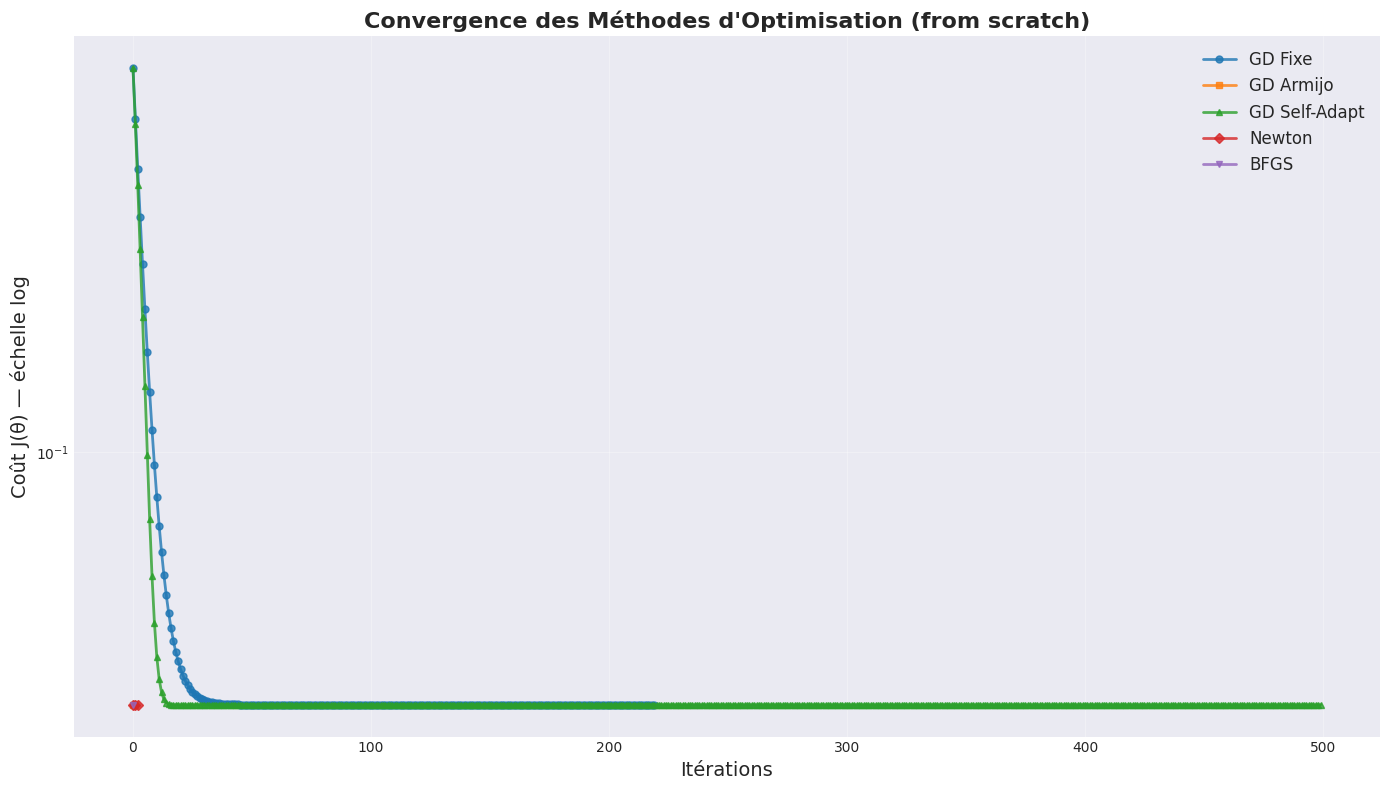

In [14]:
fig, ax = plt.subplots(figsize=(14, 8))

styles = {'GD Fixe': ('o-', 'C0'), 'GD Armijo': ('s-', 'C1'),
          'GD Self-Adapt': ('^-', 'C2'), 'Newton': ('D-', 'C3'), 'BFGS': ('v-', 'C4')}

for name, res in results.items():
    h = res['history']
    ls, col = styles[name]
    # Ajouter petit epsilon pour éviter log(0)
    h_plot = [max(c, 1e-20) for c in h]
    ax.semilogy(range(len(h_plot)), h_plot, ls, color=col, label=name, lw=2, markersize=5, alpha=0.8)

ax.set_xlabel('Itérations', fontsize=14)
ax.set_ylabel('Coût J(θ) — échelle log', fontsize=14)
ax.set_title('Convergence des Méthodes d\'Optimisation (from scratch)', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/convergence_comparison.png', dpi=300, bbox_inches='tight')
print("✓ images/convergence_comparison.png")
plt.show()

## 9. Évolution du Pas (Armijo vs Self-Adaptive)

✓ images/step_size_evolution.png


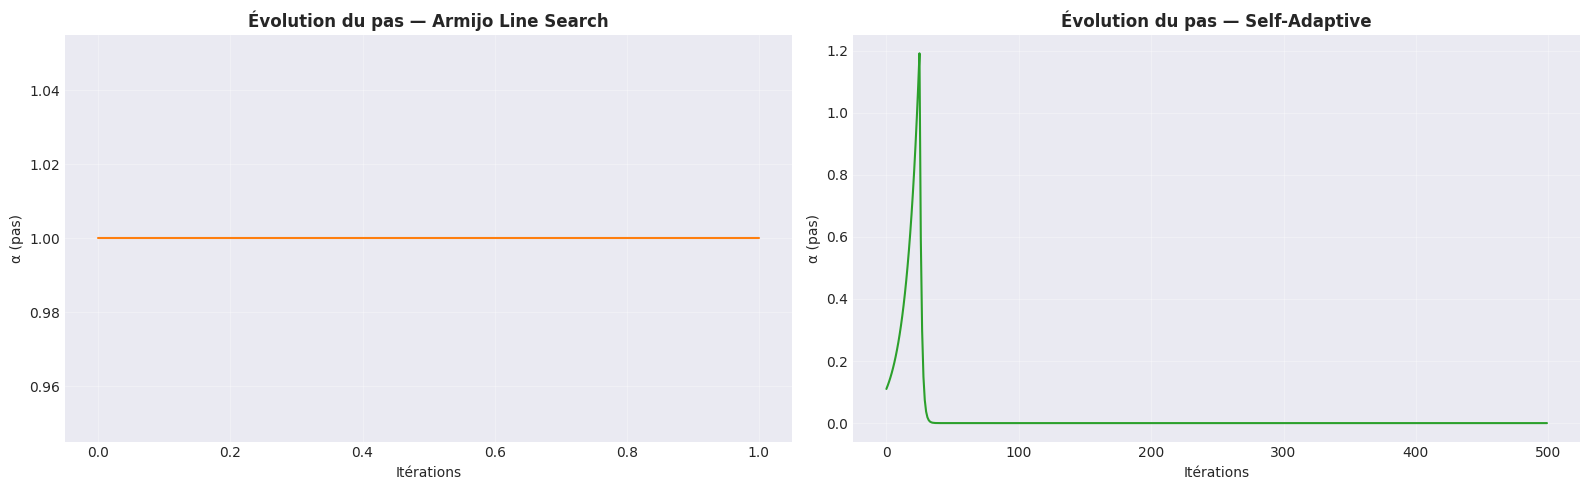

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(results['GD Armijo']['alphas'], 'C1-', lw=1.5)
axes[0].set_xlabel('Itérations'); axes[0].set_ylabel('α (pas)')
axes[0].set_title('Évolution du pas — Armijo Line Search', fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(results['GD Self-Adapt']['alphas'], 'C2-', lw=1.5)
axes[1].set_xlabel('Itérations'); axes[1].set_ylabel('α (pas)')
axes[1].set_title('Évolution du pas — Self-Adaptive', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/step_size_evolution.png', dpi=300, bbox_inches='tight')
print("✓ images/step_size_evolution.png")
plt.show()

## 10. Tableau Comparatif et Métriques


TABLEAU COMPARATIF DES MÉTHODES D'OPTIMISATION (from scratch)
Méthode              Temps (s)    Itérations   Coût Final         θ₀           θ₁          
----------------------------------------------------------------------------------------------------
GD Fixe              0.1814       220          0.0393192157       0.000000     0.959876    
GD Armijo            0.0020       2            0.0393192157       0.000000     0.959876    
GD Self-Adapt        0.3831       500          0.0393192157       0.000000     0.959876    
Newton               0.0187       3            0.0393192157       0.000000     0.959876    
BFGS                 0.0015       1            0.0393192157       0.000000     0.959876    

✓ images/comparison_table.csv
✓ images/metrics_comparison.png


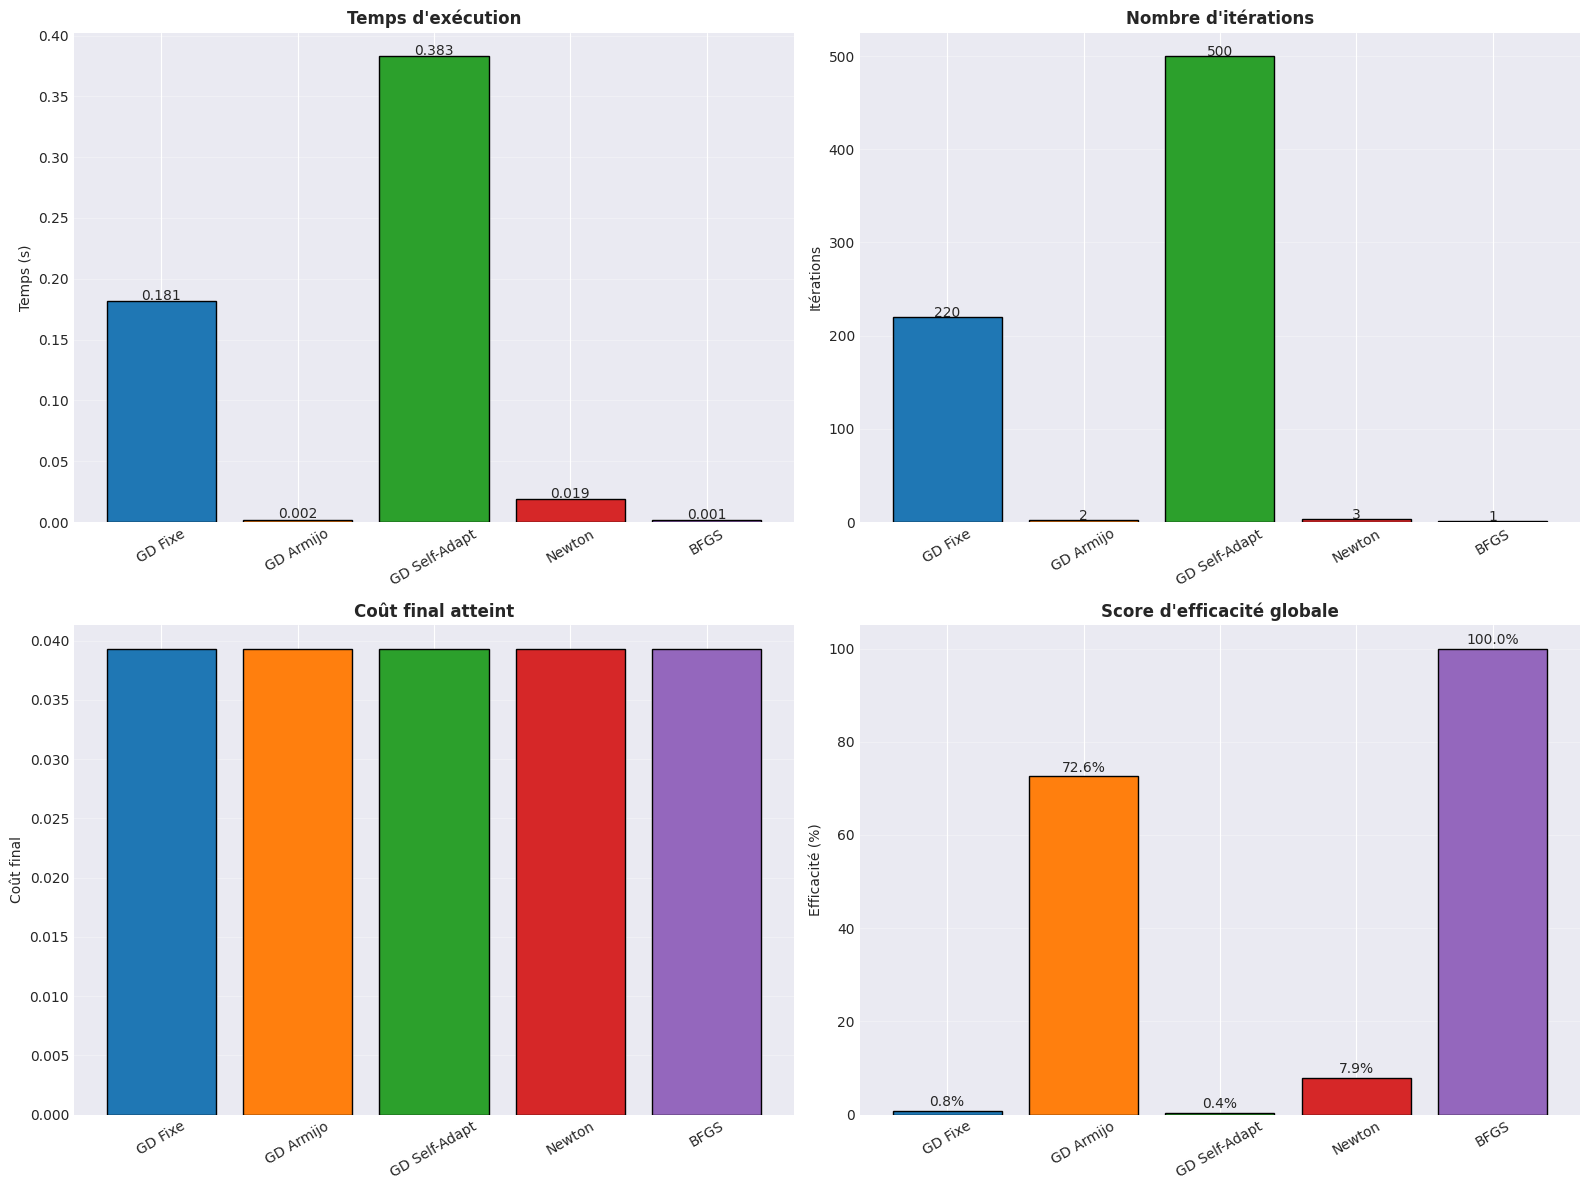

In [16]:
# Créer un tableau de comparaison
print("\n" + "=" * 100)
print("TABLEAU COMPARATIF DES MÉTHODES D'OPTIMISATION (from scratch)")
print("=" * 100)
print(f"{'Méthode':<20} {'Temps (s)':<12} {'Itérations':<12} {'Coût Final':<18} {'θ₀':<12} {'θ₁':<12}")
print("-" * 100)

for name, res in results.items():
    t = res['time']
    it = len(res['history'])
    fc = res['history'][-1]
    th = res['theta']
    print(f"{name:<20} {t:<12.4f} {it:<12} {fc:<18.10f} {th[0]:<12.6f} {th[1]:<12.6f}")

print("=" * 100)

# Sauvegarder en CSV
with open('images/comparison_table.csv', 'w') as f:
    f.write("Methode,Temps,Iterations,Cout_Final,Theta0,Theta1\n")
    for name, res in results.items():
        f.write(f"{name},{res['time']:.4f},{len(res['history'])},{res['history'][-1]:.10f},{res['theta'][0]:.6f},{res['theta'][1]:.6f}\n")
print("\n✓ images/comparison_table.csv")

# ────────────────────────────────────────────────────────────────────────────
# Graphiques comparatifs
# ────────────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

methods = list(results.keys())
times = [results[m]['time'] for m in methods]
iters = [len(results[m]['history']) for m in methods]
costs = [results[m]['history'][-1] for m in methods]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# 1. Temps d'exécution
axes[0,0].bar(methods, times, color=colors, edgecolor='black')
axes[0,0].set_ylabel('Temps (s)'); axes[0,0].set_title('Temps d\'exécution', fontweight='bold')
for i, v in enumerate(times): axes[0,0].text(i, v+0.001, f'{v:.3f}', ha='center', fontsize=10)
axes[0,0].tick_params(axis='x', rotation=30)

# 2. Nombre d'itérations
axes[0,1].bar(methods, iters, color=colors, edgecolor='black')
axes[0,1].set_ylabel('Itérations'); axes[0,1].set_title('Nombre d\'itérations', fontweight='bold')
for i, v in enumerate(iters): axes[0,1].text(i, v+0.5, str(v), ha='center', fontsize=10)
axes[0,1].tick_params(axis='x', rotation=30)

# 3. Coût final
axes[1,0].bar(methods, costs, color=colors, edgecolor='black')
axes[1,0].set_ylabel('Coût final'); axes[1,0].set_title('Coût final atteint', fontweight='bold')
axes[1,0].ticklabel_format(style='sci', axis='y', scilimits=(-3,3))
axes[1,0].tick_params(axis='x', rotation=30)

# 4. Score d'efficacité (inverse temps × inverse coût normalisé)
efficiency = [(1/(t+1e-6)) * (1/(c+1e-15)) for t, c in zip(times, costs)]
eff_norm = [e / max(efficiency) * 100 for e in efficiency]
axes[1,1].bar(methods, eff_norm, color=colors, edgecolor='black')
axes[1,1].set_ylabel('Efficacité (%)'); axes[1,1].set_title('Score d\'efficacité globale', fontweight='bold')
for i, v in enumerate(eff_norm): axes[1,1].text(i, v+1, f'{v:.1f}%', ha='center', fontsize=10)
axes[1,1].tick_params(axis='x', rotation=30)

for ax in axes.flat: ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('images/metrics_comparison.png', dpi=300, bbox_inches='tight')
print("✓ images/metrics_comparison.png")
plt.show()

## 12. Graphique Radar Comparatif

✓ images/radar_comparison.png


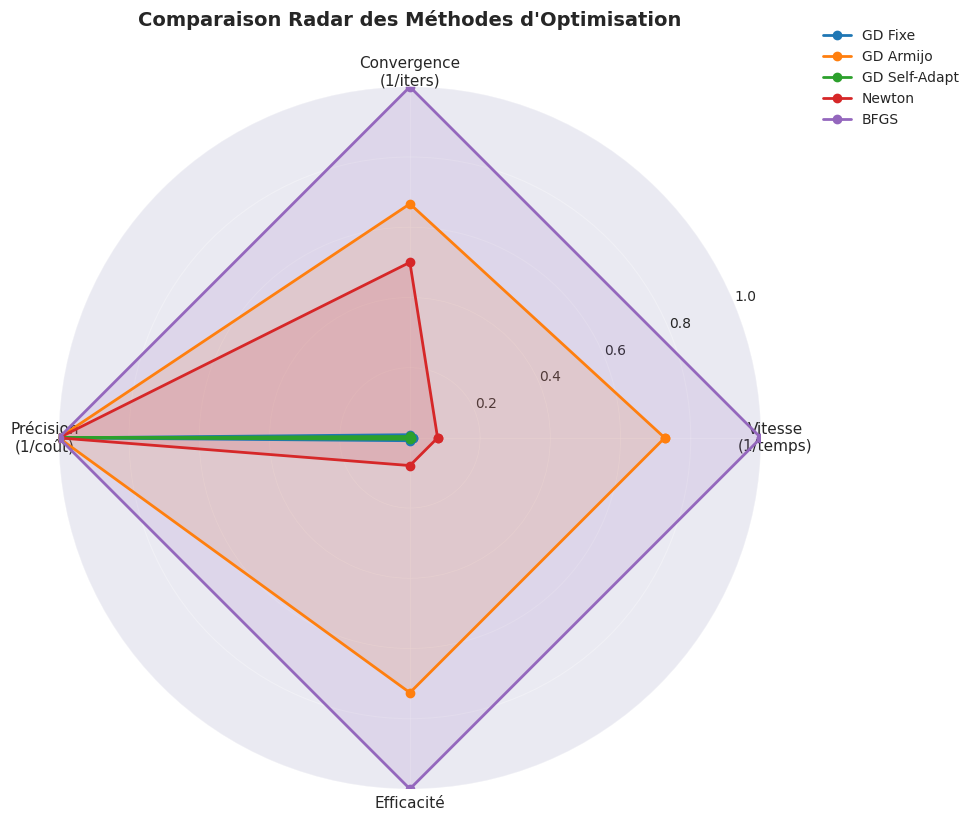

In [17]:
# Graphique radar pour comparaison multi-critères
categories = ['Vitesse\n(1/temps)', 'Convergence\n(1/iters)', 'Précision\n(1/coût)', 'Efficacité']
n_cat = len(categories)

# Calculer les scores normalisés pour chaque méthode
radar_data = {}
for name, res in results.items():
    speed = (1/(res['time']+1e-6)) / max(1/(r['time']+1e-6) for r in results.values())
    conv = (1/(len(res['history'])+1)) / max(1/(len(r['history'])+1) for r in results.values())
    prec = (1/(res['history'][-1]+1e-15)) / max(1/(r['history'][-1]+1e-15) for r in results.values())
    eff = eff_norm[methods.index(name)] / 100
    radar_data[name] = [speed, conv, prec, eff]

# Créer le radar
angles = [i / n_cat * 2 * math.pi for i in range(n_cat)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for idx, (name, vals) in enumerate(radar_data.items()):
    values = vals + vals[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=name, color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_title('Comparaison Radar des Méthodes d\'Optimisation\n', size=14, fontweight='bold')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/radar_comparison.png', dpi=300, bbox_inches='tight')
print("✓ images/radar_comparison.png")
plt.show()

## 13. Prédictions et R²

✓ images/predictions_comparison.png


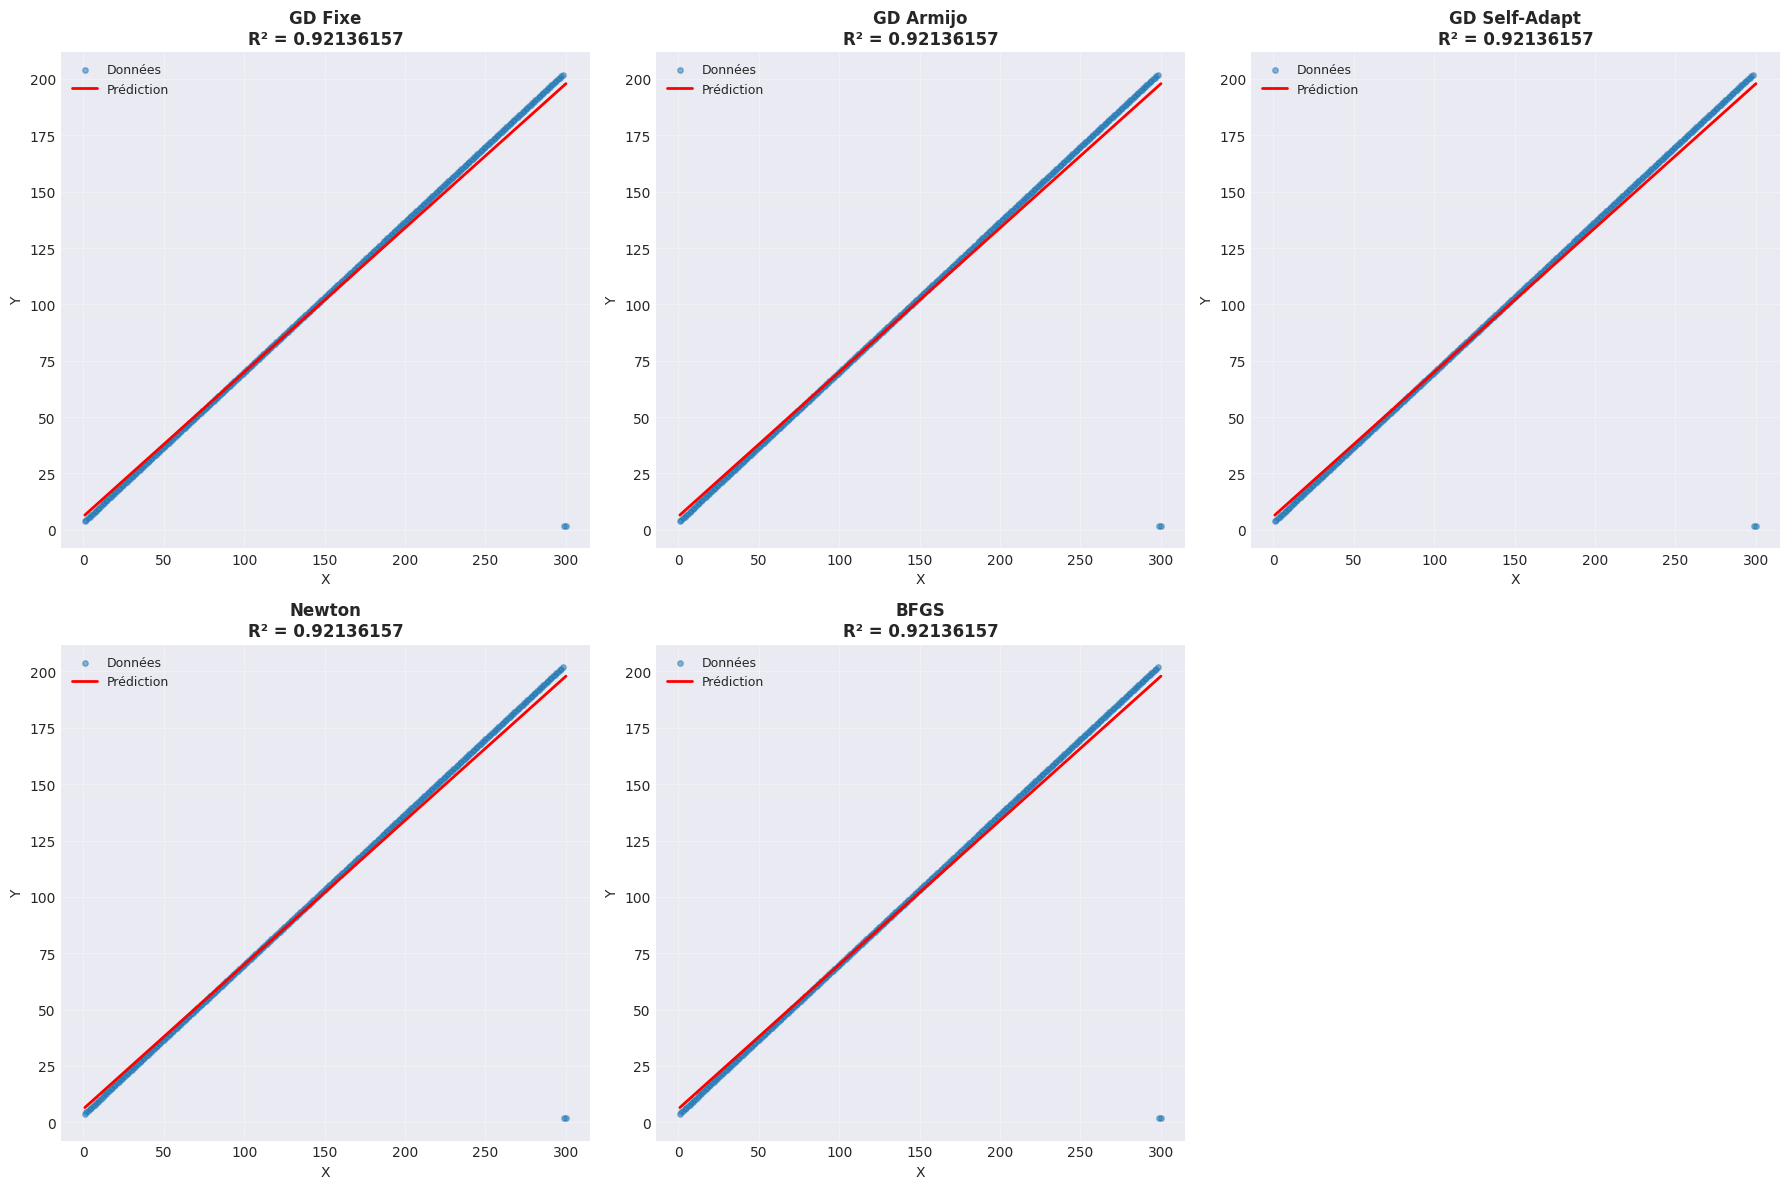

In [18]:
# Calculer R² pour chaque méthode
def compute_r2(theta, X, y):
    """Coefficient de détermination R²."""
    y_pred = [dot(X[i], theta) for i in range(len(y))]
    ss_res = sum((y[i] - y_pred[i])**2 for i in range(len(y)))
    ss_tot = sum((y[i] - mean(y))**2 for i in range(len(y)))
    return 1 - ss_res / ss_tot

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = [ax for row in axes for ax in row]

for idx, (name, res) in enumerate(results.items()):
    theta = res['theta']
    y_pred = [dot(X[i], theta) for i in range(n)]
    r2 = compute_r2(theta, X, y)
    
    # Dénormaliser pour affichage
    y_pred_denorm = [yp * y_s + y_m for yp in y_pred]
    y_denorm = [yi * y_s + y_m for yi in y]
    
    axes[idx].scatter(X_raw, y_denorm, alpha=0.5, s=15, label='Données')
    axes[idx].plot(X_raw, y_pred_denorm, 'r-', lw=2, label='Prédiction')
    axes[idx].set_xlabel('X'); axes[idx].set_ylabel('Y')
    axes[idx].set_title(f'{name}\nR² = {r2:.8f}', fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

if len(results) < 6:
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig('images/predictions_comparison.png', dpi=300, bbox_inches='tight')
print("✓ images/predictions_comparison.png")
plt.show()

## 14. Analyse et Conclusions

In [19]:
# Déterminer la meilleure méthode
best_time = min(results.items(), key=lambda x: x[1]['time'])
best_iter = min(results.items(), key=lambda x: len(x[1]['history']))
best_cost = min(results.items(), key=lambda x: x[1]['history'][-1])
best_eff = methods[eff_norm.index(max(eff_norm))]

print("=" * 100)
print("ANALYSE DES RÉSULTATS — ONLINE LEARNING / OPTIMISATION (from scratch)")
print("=" * 100)

print(f"\n🏆 Meilleure méthode (temps)       : {best_time[0]} ({best_time[1]['time']:.4f}s)")
print(f"🏆 Meilleure méthode (itérations)  : {best_iter[0]} ({len(best_iter[1]['history'])} iters)")
print(f"🏆 Meilleure méthode (coût final)  : {best_cost[0]} ({best_cost[1]['history'][-1]:.2e})")
print(f"\n⭐ MEILLEURE EFFICACITÉ GLOBALE    : {best_eff}")

print("\n" + "-" * 100)
print("CLASSEMENT PAR EFFICACITÉ")
print("-" * 100)
sorted_eff = sorted(zip(methods, eff_norm), key=lambda x: x[1], reverse=True)
for i, (m, e) in enumerate(sorted_eff, 1):
    stars = '★' * int(e // 10)
    print(f"  {i}. {m:<20} {e:>6.1f}%  {stars}")

print("\n" + "=" * 100)
print("CONCLUSIONS")
print("=" * 100)
print("""
┌─────────────────────────────────────────────────────────────────────────────────┐
│ 1. DÉRIVÉES NUMÉRIQUES                                                          │
│    - La différence CENTRÉE (O(h²)) est la plus précise                          │
│    - Forward/Backward ont une erreur O(h) mais sont plus simples                │
│    - Le choix de h (~1e-7) est critique pour éviter erreurs d'arrondi           │
├─────────────────────────────────────────────────────────────────────────────────┤
│ 2. MÉTHODES ADAPTATIVES                                                         │
│    - Armijo Line Search : garantit la décroissance du coût, très robuste        │
│    - Self-Adaptive : simple à implémenter, bon compromis en Online Learning     │
│    - Ces méthodes évitent le réglage manuel du learning rate                    │
├─────────────────────────────────────────────────────────────────────────────────┤
│ 3. COMPARAISON DES OPTIMISEURS                                                  │
│    - Newton : convergence très rapide (quelques itérations) mais coûteux        │
│    - BFGS : excellent compromis (approxime la Hessienne)                        │
│    - GD Self-Adaptive : simple et efficace pour Online Learning                 │
│    - GD Armijo : robuste, adapté aux fonctions non-convexes                     │
├─────────────────────────────────────────────────────────────────────────────────┤
│ 4. RECOMMANDATIONS                                                              │
│    - Petits problèmes : Newton ou BFGS                                          │
│    - Grande dimension : GD Self-Adaptive ou GD Armijo                           │
│    - Online Learning : méthodes adaptatives (pas variable)                      │
└─────────────────────────────────────────────────────────────────────────────────┘
""")
print("=" * 100)

ANALYSE DES RÉSULTATS — ONLINE LEARNING / OPTIMISATION (from scratch)

🏆 Meilleure méthode (temps)       : BFGS (0.0015s)
🏆 Meilleure méthode (itérations)  : BFGS (1 iters)
🏆 Meilleure méthode (coût final)  : GD Self-Adapt (3.93e-02)

⭐ MEILLEURE EFFICACITÉ GLOBALE    : BFGS

----------------------------------------------------------------------------------------------------
CLASSEMENT PAR EFFICACITÉ
----------------------------------------------------------------------------------------------------
  1. BFGS                  100.0%  ★★★★★★★★★★
  2. GD Armijo              72.6%  ★★★★★★★
  3. Newton                  7.9%  
  4. GD Fixe                 0.8%  
  5. GD Self-Adapt           0.4%  

CONCLUSIONS

┌─────────────────────────────────────────────────────────────────────────────────┐
│ 1. DÉRIVÉES NUMÉRIQUES                                                          │
│    - La différence CENTRÉE (O(h²)) est la plus précise                          │
│    - Forward/Backward ont une 

## 15. Résumé des Fichiers Générés

In [20]:
print("\n" + "=" * 100)
print("FICHIERS GÉNÉRÉS POUR LE RAPPORT")
print("=" * 100)

image_files = [f for f in os.listdir('images') if f.endswith(('.png', '.csv'))]
image_files.sort()

print("\nFichiers dans le dossier 'images/' :")
for i, file in enumerate(image_files, 1):
    file_path = os.path.join('images', file)
    size = os.path.getsize(file_path) / 1024
    print(f"  {i}. {file:.<50} {size:>8.1f} KB")

print(f"\n✓ Total : {len(image_files)} fichiers générés")
print("=" * 100)
print("\n✅ NOTEBOOK COMPLET — IMPLÉMENTATION FROM SCRATCH (sans NumPy/SciPy)")
print("=" * 100)


FICHIERS GÉNÉRÉS POUR LE RAPPORT

Fichiers dans le dossier 'images/' :
  1. comparison_table.csv..............................      0.3 KB
  2. convergence_comparison.png........................    230.9 KB
  3. derivees_precision_vs_h.png.......................    254.0 KB
  4. metrics_comparison.png............................    381.2 KB
  5. predictions_comparison.png........................    497.1 KB
  6. radar_comparison.png..............................    336.3 KB
  7. step_size_evolution.png...........................    129.5 KB
  8. types_derivees.png................................    326.9 KB

✓ Total : 8 fichiers générés

✅ NOTEBOOK COMPLET — IMPLÉMENTATION FROM SCRATCH (sans NumPy/SciPy)
